In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
import requests
from datetime import datetime
from ast import literal_eval as make_tuple

from functions.plot_prod import plot_prod

In [2]:
sns.set_style("whitegrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
year=2020
country='de'
lang='en'

In [5]:
url = f'https://energy-charts.info/charts/power/data/{country}/year_cbpf_saldo_{year}.json'

In [6]:
s = requests.Session()
r = s.get(url)
    
s.close()

response = json.loads(r.text)

In [7]:
ticks = [datetime.utcfromtimestamp(d/1000) for d in response[0]['xAxisValues']]

In [8]:
trade = []
regions = []

for r in response:
    trade.append(r['data'])
    regions.append(r['name'][0][lang])

In [9]:
colors = {t:tuple(c/255 for c in make_tuple(r['color'][3:])) for r,t in zip(response,regions)}
colors = {**colors, **{'_'+k:v for k,v in colors.items()}}

In [10]:
trade_df = pd.DataFrame(data=trade,
                      index=regions,
                      columns=ticks).T

(-18.4602, 15.6035)

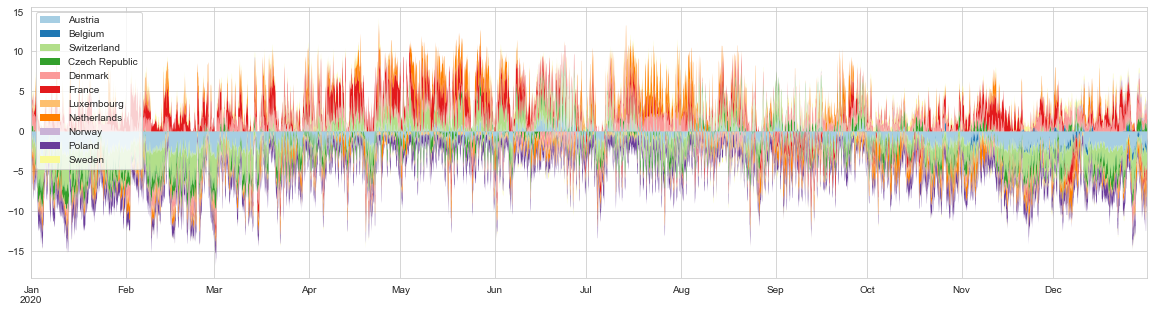

In [11]:
df_neg, df_pos = trade_df.drop('sum',axis=1).clip(upper=0), trade_df.drop('sum',axis=1).clip(lower=0)


fig, ax = plt.subplots(figsize=(20,5),
                       facecolor='w')

df_pos.plot.area(stacked=True,
                 linewidth=0.,
                 color=colors,
                 ax=ax)

df_neg.rename(columns=lambda x: '_' + x, inplace=True)

df_neg.plot.area(ax=ax,
                stacked=True,
                linewidth=0.,
                color=colors)

# handles, labels = ax.get_legend_handles_labels()

# plt.legend(handles=handles,
#            loc='center left',
#            bbox_to_anchor=(1, 0.5))

ax.set_ylim([df_neg.sum(axis=1).min()*1.1,
             df_pos.sum(axis=1).max()*1.1])

In [12]:
# trade_summary=pd.concat([df_neg.sum(), df_pos.sum(),trade_df.sum()],axis=1,keys=['exports','imports','balance'])
# trade_summary.to_excel(f'output/trade_{country}_{year}.xlsx')